In [85]:
import numpy as np
import matplotlib.pyplot as plt
import polarTools as pt

## Implementation of Raman et. al. 2010 ORN Model ##

l_odorspace = 2		# Number of Parameters that define Odorants

# More parameters generally means a sparser response by ORNs 

odor = pt.generateUniform(1,l_odorspace) # Odorant Identity in Odor Space

# The Magnitude of Odor Vector is proportional to Concentration

In [97]:
def generate_orn(duration,resolution,odorVec,odorStart,odorEnd): # Function to generate single ORN Trace
    
    baseline = 0.2 # Baseline Firing Rate
    trace = baseline*np.ones(int(duration/resolution))
    rec_field = pt.generateUniform(1,l_odorspace) # Receptive Field of ORNs in Odor Space
    
    latency = np.random.uniform(0,200) # Latency of Response to Odor Presentation
    t_rise = np.random.uniform(0,600) # Time to Rise to Peak
    t_fall = np.random.uniform(0,1200) # Response Decay Time
    tuning = np.random.uniform(1,15) # Odor Tuning-width / Sensitivity
    
    
    def sigmoid(x,a1=15,a2=0.8):	# Sigmoid for Response
        return 1/(1+np.exp(-a1*(x-a2)))
    
    odorMag = np.linalg.norm(odorVec) # Odor Concentration
    cosSim = np.dot(odorVec,rec_field)/(np.linalg.norm(odorVec)*np.linalg.norm(rec_field)) # Cosine Similarity wrt Odor
    

    if np.arccos(cosSim) < np.pi*60/180:	# Minimum Response Threshhold
        res_strength = (1-baseline)*sigmoid(odorMag*np.cos(np.arccos(cosSim)/2)**tuning)
    else:
        res_strength = -baseline
    
    
    if np.random.uniform()<0.5:
        
        response_type='sharp' # Sharp Response to Odor
        
        # Generate Sharp Trace

        rise = np.arange(0,t_rise/2,resolution)
        rise = baseline+res_strength*2*np.exp(1)/t_rise*rise*np.exp(-2*rise/t_rise)
        
        riseStartIndex = int((odorStart+latency)/resolution)
        riseEndIndex = riseStartIndex+rise.shape[0]
        
        trace[riseStartIndex:riseEndIndex] = rise
        
        peak = rise[-1]
        
        fall = np.linspace(0,duration-riseEndIndex*resolution,trace.shape[0]-riseEndIndex)
        fall = (peak-baseline)*np.exp(-fall/t_fall)+baseline
        
        fallStartIndex = riseEndIndex
        trace[fallStartIndex:] = fall
    
    else:
        
        response_type='broad' # Broad Response to Odor
        
        # Generate Broad Trace

        rise = np.arange(0,t_rise,resolution)
        rise = baseline+res_strength*np.exp(1)/t_rise*rise*np.exp(-rise/t_rise)
        
        riseStartIndex = int((odorStart+latency)/resolution)
        riseEndIndex = int((odorStart+latency)/resolution)+rise.shape[0]
        
        trace[riseStartIndex:riseEndIndex] = rise
        
        peak_1 = rise[-1]
        
        adaptation_rate = np.random.uniform(0.1,1) # Amplitude of Adaptation-related Decay
        t_adaptation = np.random.uniform(0,1200) # Odor Adaptation Time
        
        adaptation = np.arange(0,(int(odorEnd/resolution)-riseEndIndex)*resolution,resolution)

#         if res_strength>0:
#             #adaptation = np.linspace(peak_1,adaptation_rate*res_strength,adaptation.shape[0],endpoint=False)
#             #adaptation = (peak_1-(adaptation_rate*res_strength+baseline))*np.exp(-adaptation/t_adaptation)+(adaptation_rate*res_strength+baseline)
#         else:
#             adaptation = np.zeros(adaptation.shape)
        adaptation = (peak_1-(adaptation_rate*res_strength+baseline))*np.exp(-adaptation/t_adaptation)+(adaptation_rate*res_strength+baseline)
        
        adaptationStartIndex = riseEndIndex
        adaptationEndIndex = adaptationStartIndex+adaptation.shape[0]
        
        trace[adaptationStartIndex:adaptationEndIndex] = adaptation
        
        peak_2 = adaptation[-1]
        
        fall = np.arange(0,(trace.shape[0]-adaptationEndIndex)*resolution,resolution)
        fall = (peak_2-baseline)*np.exp(-fall/t_fall) + baseline
        
#         fall = baseline*np.ones(fall.shape)
        
        fallStartIndex = adaptationEndIndex
        
        trace[fallStartIndex:] = fall
    
    time = np.arange(0,duration,resolution)
    
    return time,trace

# Generate Odor Response

orns = []

for i in range(100):	# Generate 100 ORN types
    time,trace = generate_orn(6000,0.01,odor,500,2500)
    orns.append(trace)

orns = np.array(orns*10)*25 # Make 10 replicates of each ORN

# Plot ORN Responses
plt.figure()
order = np.argsort(orns.max(axis=1))
plt.imshow(orns[order[::-1],::100], aspect='auto')
plt.colorbar()
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.title('ORN Response')
plt.show()

plt.figure()
order = np.argsort(orns.mean(axis=1))
plt.plot(orns[:100,::100].T)
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.title('ORN Response')
plt.show()

# Plot EAD
plt.figure()
plt.plot(np.matmul(orns.T,np.ones((1000,1)))/1000)
plt.xlabel('Time (in ms)')
plt.ylabel('Mean Firing Rate')
plt.title('EAG Response')
plt.show()

In [95]:
# Generate ORN-AL Connectivity (1000 ORNs to 90 PNs and 30 LNs)

ORN_AL = np.zeros((1000,120))

p_PN = 0.05
p_LN = 0.7

n_PN = int(100*p_PN)
n_LN = int(1000*p_LN)

pn = []
for i in range(90):
    x = [1]*n_PN+[0]*(100-n_PN)
    np.random.shuffle(x)
    pn.append(x)
ORN_AL[:,:90] = np.array(list(np.array(pn).T)*10)
# ORN_AL[:,:90] = np.array(list(np.random.choice([0,1],size=(100,90),p=[1-p_PN,p_PN]))*10)

ln = []
for i in range(30):
    x = [1]*n_LN+[0]*(1000-n_LN)
    np.random.shuffle(x)
    ln.append(x)
ORN_AL[:,90:] = np.array(ln).T
# ORN_AL[:,90:] = np.random.choice([0,1],size=(1000,30),p=[1-p_LN,p_LN])

# Generate Antennal Output

ORN_Output = np.matmul(orns.T,ORN_AL).T

PN_current = 10
LN_current = 8

PN_scale = PN_current/ORN_Output[:90,50000:150000].max() # PN Scaling Factor
LN_scale = LN_current/ORN_Output[90:,50000:150000].max() # LN Scaling Factor

# Scale ORN Output to AL Input
ORN_Output[:90,:] = (ORN_Output[:90,:] * PN_scale)
ORN_Output[90:,:] = (ORN_Output[90:,:] * LN_scale)

plt.figure()
order = np.argsort(ORN_Output[:90,:].max(axis=1))
plt.imshow(ORN_Output[order[::-1],::100], aspect='auto')
plt.colorbar()
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.show()

plt.figure()
order = np.argsort(ORN_Output[90:120,:].max(axis=1))
plt.imshow(ORN_Output[90+order[::-1],::100], aspect='auto')
plt.colorbar()
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.show()


In [92]:
plt.figure()
plt.plot(ORN_Output[90:120,::100].T)
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.show()

In [93]:
plt.figure()
plt.plot(ORN_Output[:90,::100].T)
plt.xlabel('Time (in ms)')
plt.ylabel('Neuron Number')
plt.show()

In [6]:
np.save('current_input',ORN_Output)

In [7]:
from sklearn.decomposition import PCA

In [8]:
model = PCA(n_components=2)

In [10]:
out = model.fit_transform(ORN_Output[:90,:])

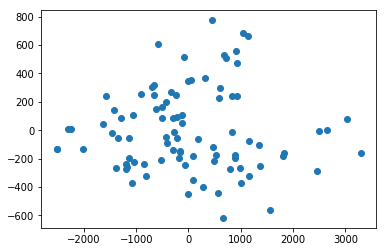

In [11]:
plt.scatter(out[:,0],out[:,1])

In [12]:
def generate_orn(duration,resolution,odorVec,odorStart,odorEnd,sharp=True,t_fall=300,exi=False): # Function to generate single ORN Trace
    
    baseline = np.random.normal(0.1,0.01) # Baseline Firing Rate
    trace = baseline*np.ones(int(duration/resolution))
    rec_field = np.random.uniform(0,1,l_odorspace) # Receptive Field of ORNs in Odor Space
    
    latency = 0 # Latency of Response to Odor Presentation
    t_rise = 300 # Time to Rise to Peak
    tuning = 1 # Odor Tuning-width / Sensitivity
    
    def sigmoid(x,a1=15,a2=0.8):	# Sigmoid for Response
        return 1/(1+np.exp(-a1*(x-a2)))
    
    odorMag = 1 # Odor Concentration
    cosSim = 1 # Cosine Similarity wrt Odor
    

    if exi:	# Minimum Response Threshhold
        res_strength = (1-baseline)*sigmoid(odorMag*cosSim**tuning)
    else:
        res_strength = -baseline
    
    
    if sharp:
        
        response_type='sharp' # Sharp Response to Odor
        
        # Generate Sharp Trace

        rise = np.arange(0,t_rise/2,resolution)
        rise = baseline+res_strength*2*np.exp(1)/t_rise*rise*np.exp(-2*rise/t_rise)
        
        riseStartIndex = int((odorStart+latency)/resolution)
        riseEndIndex = riseStartIndex+rise.shape[0]
        
        trace[riseStartIndex:riseEndIndex] = rise
        
        peak = rise[-1]
        
        fall = np.linspace(0,duration-riseEndIndex*resolution,trace.shape[0]-riseEndIndex)
        fall = (peak-baseline)*np.exp(-fall/t_fall)+baseline
        
        fallStartIndex = riseEndIndex
        trace[fallStartIndex:] = fall
    
    else:
        
        response_type='broad' # Broad Response to Odor
        
        # Generate Broad Trace

        rise = np.arange(0,t_rise,resolution)
        rise = baseline+res_strength*np.exp(1)/t_rise*rise*np.exp(-rise/t_rise)
        
        riseStartIndex = int((odorStart+latency)/resolution)
        riseEndIndex = int((odorStart+latency)/resolution)+rise.shape[0]
        
        trace[riseStartIndex:riseEndIndex] = rise
        
        peak_1 = rise[-1]
        
        adaptation_rate = 0.5#np.random.uniform(0.1,1) # Amplitude of Adaptation-related Decay
        t_adaptation = np.random.uniform(0,1200) # Odor Adaptation Time
        
        adaptation = np.arange(0,(int(odorEnd/resolution)-riseEndIndex)*resolution,resolution)

#         if res_strength>0:
#             #adaptation = np.linspace(peak_1,adaptation_rate*res_strength,adaptation.shape[0],endpoint=False)
#             #adaptation = (peak_1-(adaptation_rate*res_strength+baseline))*np.exp(-adaptation/t_adaptation)+(adaptation_rate*res_strength+baseline)
#         else:
#             adaptation = np.zeros(adaptation.shape)
        adaptation = (peak_1-(adaptation_rate*res_strength+baseline))*np.exp(-adaptation/t_adaptation)+(adaptation_rate*res_strength+baseline)
        
        adaptationStartIndex = riseEndIndex
        adaptationEndIndex = adaptationStartIndex+adaptation.shape[0]
        
        trace[adaptationStartIndex:adaptationEndIndex] = adaptation
        
        peak_2 = adaptation[-1]
        
        fall = np.arange(0,(trace.shape[0]-adaptationEndIndex)*resolution,resolution)
        fall = (peak_2-baseline)*np.exp(-fall/t_fall) + baseline
        
#         fall = baseline*np.ones(fall.shape)
        
        fallStartIndex = adaptationEndIndex
        
        trace[fallStartIndex:] = fall
    
    time = np.arange(0,duration,resolution)
    
    return time,trace

In [13]:
orns=[]
for i in range(100):	# Generate 100 ORN types
    time,trace = generate_orn(3000,0.01,odor,200,1200)
    orns.append(trace)

sharp = np.array(orns).mean(axis=0)

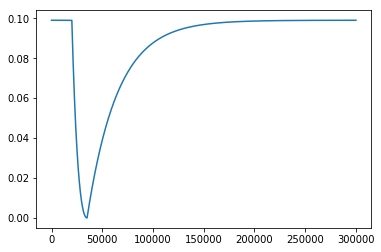

In [14]:
plt.plot(sharp)

In [15]:
orns=[]
for i in range(100):	# Generate 100 ORN types
    time,trace = generate_orn(3000,0.01,odor,200,1200,sharp=False,t_fall=300,exi=True)
    orns.append(trace)

fast = np.array(orns).mean(axis=0)

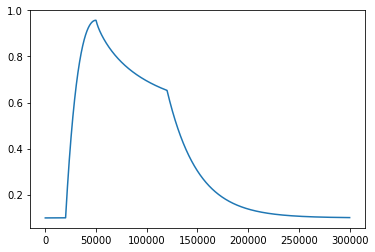

In [16]:
plt.plot(fast)

In [17]:
orns=[]
for i in range(100):	# Generate 100 ORN types
    time,trace = generate_orn(3000,0.01,odor,200,1200,sharp=False,t_fall=900)
    orns.append(trace)

slow = np.array(orns).mean(axis=0)

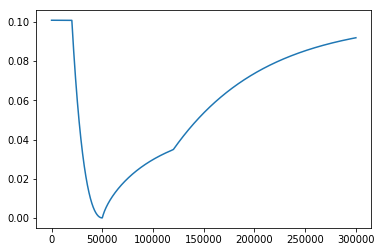

In [18]:
plt.plot(slow)

In [19]:
np.save('current_input',np.array([sharp,slow,fast]))

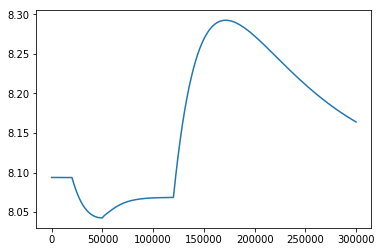

In [20]:
plt.plot(1*(1-fast)+8*(1-slow))

In [45]:
import easygui

model_path = easygui.filesavebox(msg='Open Locust File',title='Locust Browser',default='{}.locust'.format(),filetypes=['*.locust','*.pkl'])

In [25]:
def ct(r, arr):
    a = np.concatenate((np.array([2*np.pi]), arr))
    si = np.sin(a)
    si[0] = 1
    si = np.cumprod(si)
    co = np.cos(a)
    co = np.roll(co, -1)
    return si*co*r

In [66]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

points = []
for i in range(10000):
    a = ct(1,np.concatenate((np.arccos(np.random.uniform(-1,1,size=2)),np.random.uniform(0,2*np.pi,size=1)),axis=None))
    points.append(a)
ax.scatter(np.array(points).T[0],np.array(points).T[1],np.array(points).T[2],'o',alpha=0.2)


In [53]:
%matplotlib qt4